In [1]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

In [2]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants as aconst


import simdata

%reload_ext autoreload
%autoreload 2
from importlib import reload
from pprint import pprint
from functools import lru_cache

from simdata_vorticity import provide_simulation_data, velocity_cartesian_simdata, velocity_polar_simdata, roll_data
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D

%matplotlib widget

In [3]:
# @lru_cache
def calc_cartesian_velocity(simid, Noutput):
    data = simdata.SData(simid)
    rv = velocity_cartesian_simdata(data, Noutput)
    return rv

# @lru_cache
def get_polar_velocity(simid, Noutput):
    data = simdata.SData(simid)
    rv = velocity_polar_simdata(data, Noutput)
    return rv


def select_radial_range(nlow, nhigh, *args):
    rv = (x[nlow:nhigh] for x in args)
    return rv

In [100]:
# # nice vortex
simid = "139400f3"
Noutput = 101

# half jupiter mass
# simid = "488d6df2"
# Noutput = 100

# # standard model
# simid = "b522b88a"
# Noutput = 51

# secondary vortex model
# simid = "5c8cd8da"
# Noutput = 400

# self gravity beta=1
# simid = "390b95d1"
# Noutput = 20

# growing planet, band
# simid = "06f2cc46"
# Noutput = 40
# # Noutput = 100
# Noutput = 125

# beta1 alpha-4 fargo 8cps
# simid = "9428f411"
# Noutput = 21

Rlims = [5.2, 10]

data = simdata.SData(simid)

R, Phi, A, vortensity, vorticity, Rho, Rho_background, Nroll = provide_simulation_data(simid, Noutput, skip_cache=False, calc_kwargs={"return_Nroll" : True})
#vorticity -= 1
nl = np.argmin(np.abs(R[:,0]-Rlims[0]))
nr = np.argmin(np.abs(R[:,0]-Rlims[1]))
R, Phi, A, vortensity, vorticity, Rho, Rho_background = select_radial_range(nl, nr, R, Phi, A, vortensity, vorticity, Rho, Rho_background)

# get cartesian velocitites
X, Y, Vx, Vy = select_radial_range(nl, nr, *calc_cartesian_velocity(simid, Noutput))

# get polar velocities
Vr, Vphi, Vk = select_radial_range(nl, nr, *get_polar_velocity(simid, Noutput))

# get energy
M = Rho*A
e_field = data.fluids["gas"].get("2d", "energy density", Noutput)
Edens, = select_radial_range(nl, nr, np.roll(e_field.data, Nroll, axis=1))
Edens = Edens.to_value("solMass/yr2")
E = Edens*A
Espec = E/M

# calculate temperature
cV = 5/2*aconst.k_B/(2*u.u)
T = (Espec*(u.au**2/u.yr**2)/cV).decompose()#.to_value("K")

# calculate pressure
gamma = 1.4
P = Edens * (gamma-1)

# calculate cs2
Cs2_adb = P/Rho
Cs_iso = Vk*0.05

T

<Quantity [[102.46430091, 102.46674163, 102.46893354, ..., 102.45688315,
            102.45927031, 102.4617865 ],
           [102.16151254, 102.16392954, 102.16617891, ..., 102.15406646,
            102.15649134, 102.15900986],
           [101.85996812, 101.86238105, 101.86475853, ..., 101.85280723,
            101.85514314, 101.85754196],
           ...,
           [ 53.81733257,  53.81711071,  53.81689619, ...,  53.8180405 ,
             53.81779765,  53.8175616 ],
           [ 53.64977689,  53.64962563,  53.64948119, ...,  53.65027149,
             53.65009984,  53.64993496],
           [ 53.48324641,  53.48315795,  53.48307678, ...,  53.48355798,
             53.48344622,  53.48334242]] K>

CPU times: user 1.11 s, sys: 741 ms, total: 1.85 s
Wall time: 488 ms


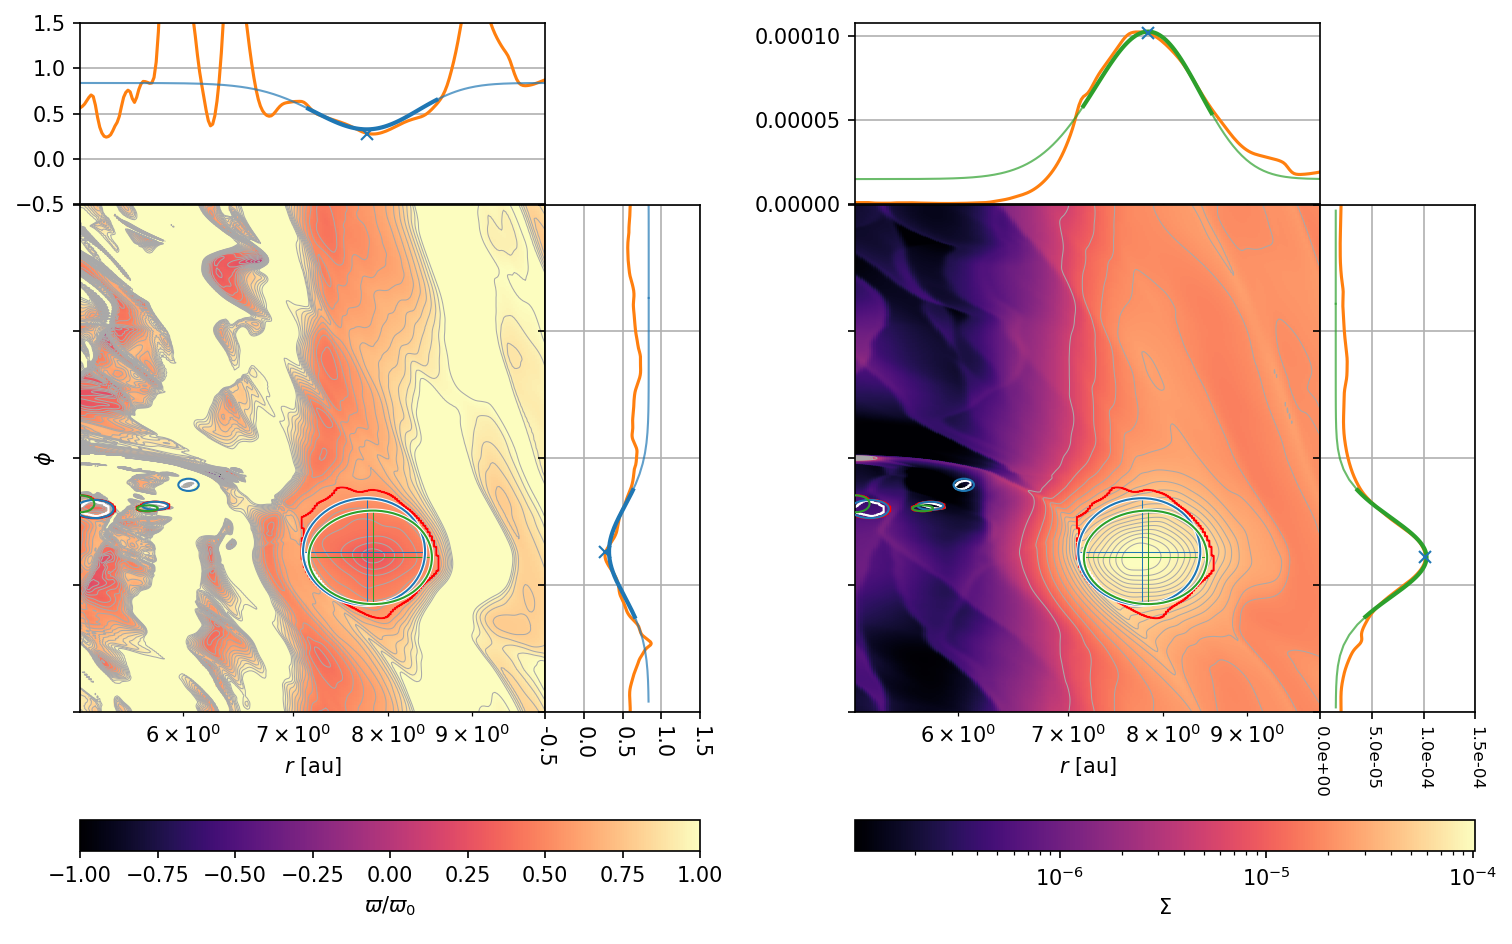

In [99]:
%matplotlib inline
vd = Vortector(R, Phi, A, vorticity, Rho, levels=np.linspace(-1,1,41))
%time vortices = vd.detect(include_mask=True, keep_internals=True, blur=0)

show_fit_overview_2D(vd, xscale="log")

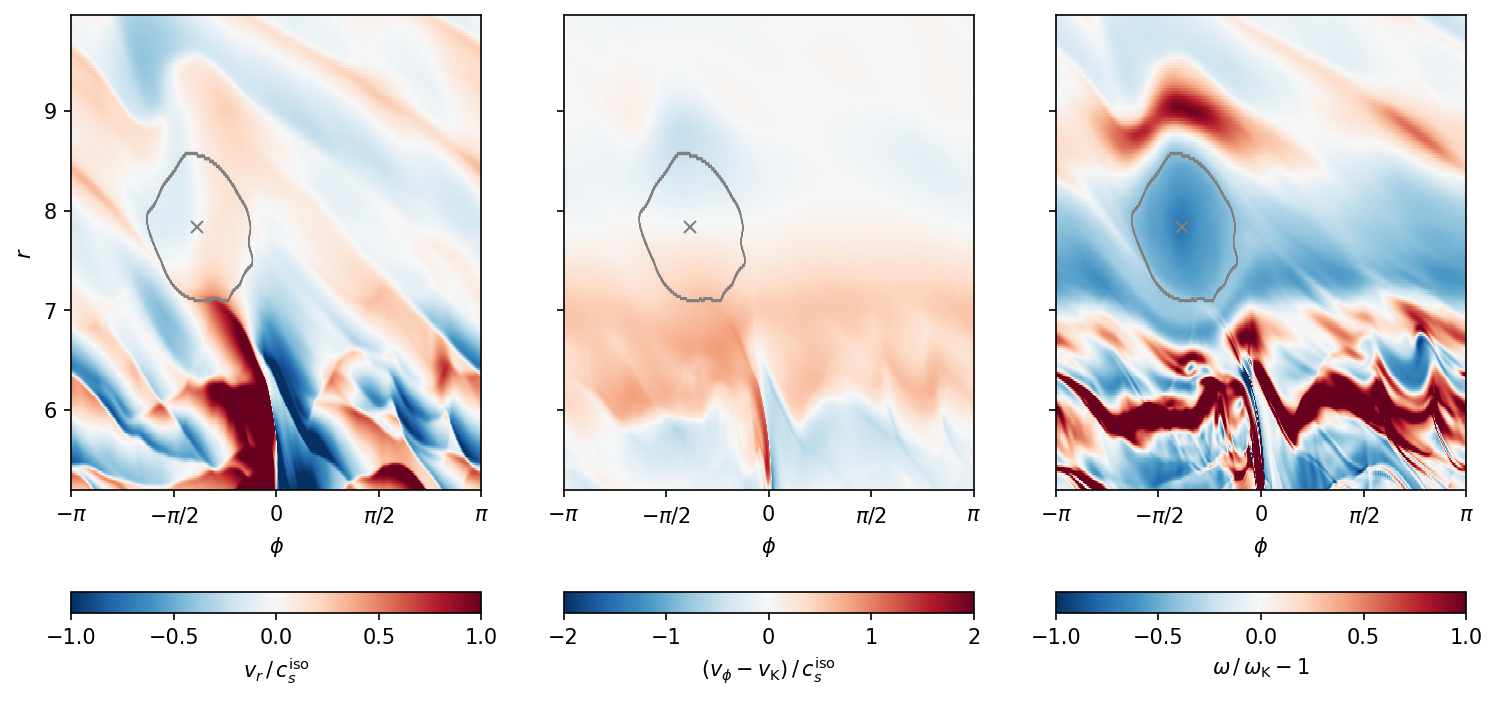

In [62]:
%matplotlib inline
fig, axes = plt.subplots(1,3,sharey="all", dpi=150, figsize=(12,6))

cbar_orientation = "horizontal"
# cbar_orientation = "vertical"

ax = axes[0]
vscale = 1
vmin, vmax = -vscale, vscale

im = ax.pcolormesh(Phi, R, Vr/Cs_iso, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$v_r \,/\, c_s^\mathrm{iso}$")

ax = axes[1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, (Vphi-Vk)/Cs_iso, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$(v_\phi - v_\mathrm{K}) \,/\, c_s^\mathrm{iso}$")

ax = axes[2]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, vorticity -1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$\omega\,/\,\omega_\mathrm{K} - 1$")

try:
    vort = vd.vortices[0]
except IndexError:
    vort = None

if vort is not None:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="Grey", linewidths=0.5)
        r, phi = vort["contour"]["stats"]["vortensity_min_pos"]
        ax.plot([phi], [r], "x", color="Grey")

axes[0].set_ylabel("$r$")
for ax in axes:
    ax.set_xticks(np.array([-1,-0.5,0,0.5,1])*np.pi)
    ax.set_xticklabels(["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
    ax.set_xlabel("$\phi$")


In [29]:
%matplotlib widget
fig, axes = plt.subplots(1,2,dpi=150, figsize=(8,4))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
Nsub = 10


def zoomed_quiver(ax, R, Phi, Vr, Vphi, sub=(1,1), bb=[[0,-1],[0,-1]]):
    xl, xu, yl, yu = bb[0][0], bb[0][1], bb[1][0], bb[1][1]
    if xu < xl:
        xl, xu = 0, -1
    if yu < yl:
        yl, yu = 0, -1
    sx, sy = sub
    X = R[xl:xu:sx, yl:yu:sy]
    Y = Phi[xl:xu:sx, yl:yu:sy]
    U = Vr[xl:xu:sx, yl:yu:sy]
    V = Vphi[xl:xu:sx, yl:yu:sy]
    U = np.sign(U)*np.log( np.abs(U)/np.min(np.abs(U)) )
    V = np.sign(V)*np.log( np.abs(V)/np.min(np.abs(V)) )
    ax.quiver(X, Y, U, V)

for ax in axes:
    ax.pcolormesh(Phi, R, Rho/Rho_background, norm=colors.LogNorm(vmin=1e-3))

zoomed_quiver(
    axes[0], 
    Phi, R,
    ((Vphi - Vk)/Cs_iso).decompose().value,
    (Vr/Cs_iso).decompose().value,
    sub=(3,30)
)

    
for vort in vd.vortices[:1]:
    bb = vd.get_bbox(vort, region="combined")
    bbox_inds = [[bb["xlow"]["inds"][0], bb["xhigh"]["inds"][0]],
                 [bb["ylow"]["inds"][1], bb["yhigh"]["inds"][1]]]
    axes[1].set_ylim([bb["xlow"]["pos"][0], bb["xhigh"]["pos"][0]])
    xmin, xmax = [bb["ylow"]["pos"][1], bb["yhigh"]["pos"][1]]
    if xmin < xmax:
        axes[1].set_xlim()


    zoomed_quiver(
        axes[1], 
        Phi, R,
        ((Vphi - Vk)/Cs_iso).decompose().value,
        (Vr/Cs_iso).decompose().value,
        bb=bbox_inds,
        sub=(1,10)
    )


for vort in vd.vortices[:1]:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5, levels=[0.5])

ax.set_xlabel("$\phi$")
ax.set_ylabel("$r$")

ax.set_title("Velocities $v_r\,/\,c_s^\mathrm{iso}$ and $(v_\phi - v_\mathrm{K})\,/\,c_s^\mathrm{iso}$ , log length")

Text(0.5, 1.0, 'Velocities $v_r\\,/\\,c_s^\\mathrm{iso}$ and $(v_\\phi - v_\\mathrm{K})\\,/\\,c_s^\\mathrm{iso}$ , log length')

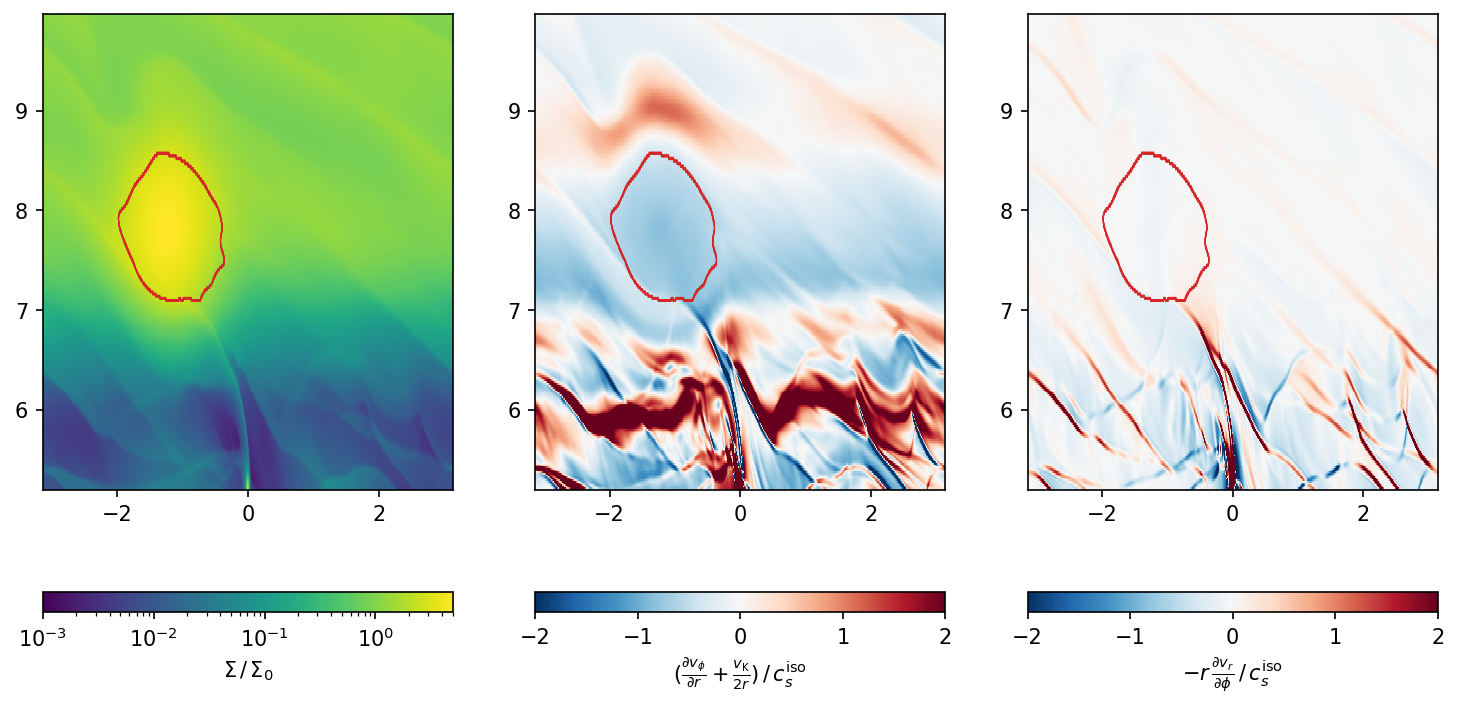

In [47]:
%matplotlib inline
from matplotlib.colors import LogNorm
dvphi_dr = np.gradient(Vphi, R[:,0], axis=0)
dvr_dphi = np.gradient(Vr, Phi[0], axis=1)

fig, axes = plt.subplots(1,3,dpi=150, figsize=(12,6))

ax = axes[0]
vmin, vmax = 1e-3, None
im = ax.pcolormesh(Phi, R, Rho/Rho_background, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\Sigma \,/\, \Sigma_0$")

ax = axes[1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, (dvphi_dr + Vk/R/2)/Cs, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$(\frac{\partial v_\phi}{\partial r} + \frac{v_\mathrm{K}}{2r})\,/\, c_s^\mathrm{iso}$")

ax = axes[2]
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, -dvr_dphi/Cs/R, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$-r \, \frac{\partial v_r}{\partial \phi}  \,/\, c_s^\mathrm{iso}$")

# show vortex contour
if vort is not None:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5)

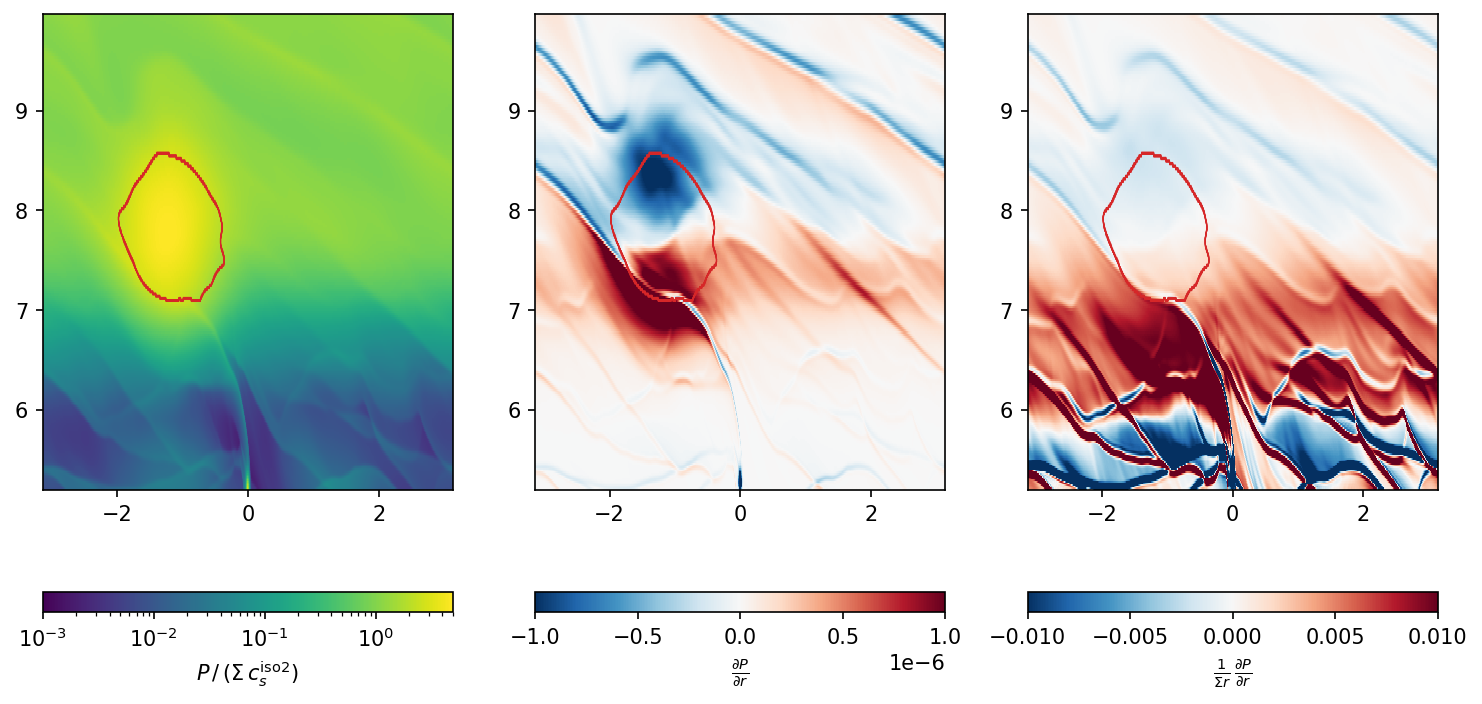

In [73]:
%matplotlib inline
from matplotlib.colors import LogNorm
dvphi_dr = np.gradient(Vphi, R[:,0], axis=0)
dvr_dphi = np.gradient(Vr, Phi[0], axis=1)

fig, axes = plt.subplots(1,3,dpi=150, figsize=(12,6))

P0 = (Cs_iso.to_value("au/yr")**2)*Rho_background

ax = axes[0]
vmin, vmax = 1e-3, 5
im = ax.pcolormesh(Phi, R, P/P0, cmap="viridis", norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$P\,/\,(\Sigma\,{c_s^\mathrm{iso}}^2)$")

dP_dr = np.gradient(P, R[:,0], axis=0)

ax = axes[1]
vscale = 1e-6
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dP_dr , cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\frac{\partial P}{\partial r}$")

ax = axes[2]
vscale = 1e-2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dP_dr/Rho/R, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\frac{1}{\Sigma r}\,\frac{\partial P}{\partial r}$")


# show vortex contour
if vort is not None:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C3", linewidths=0.5)

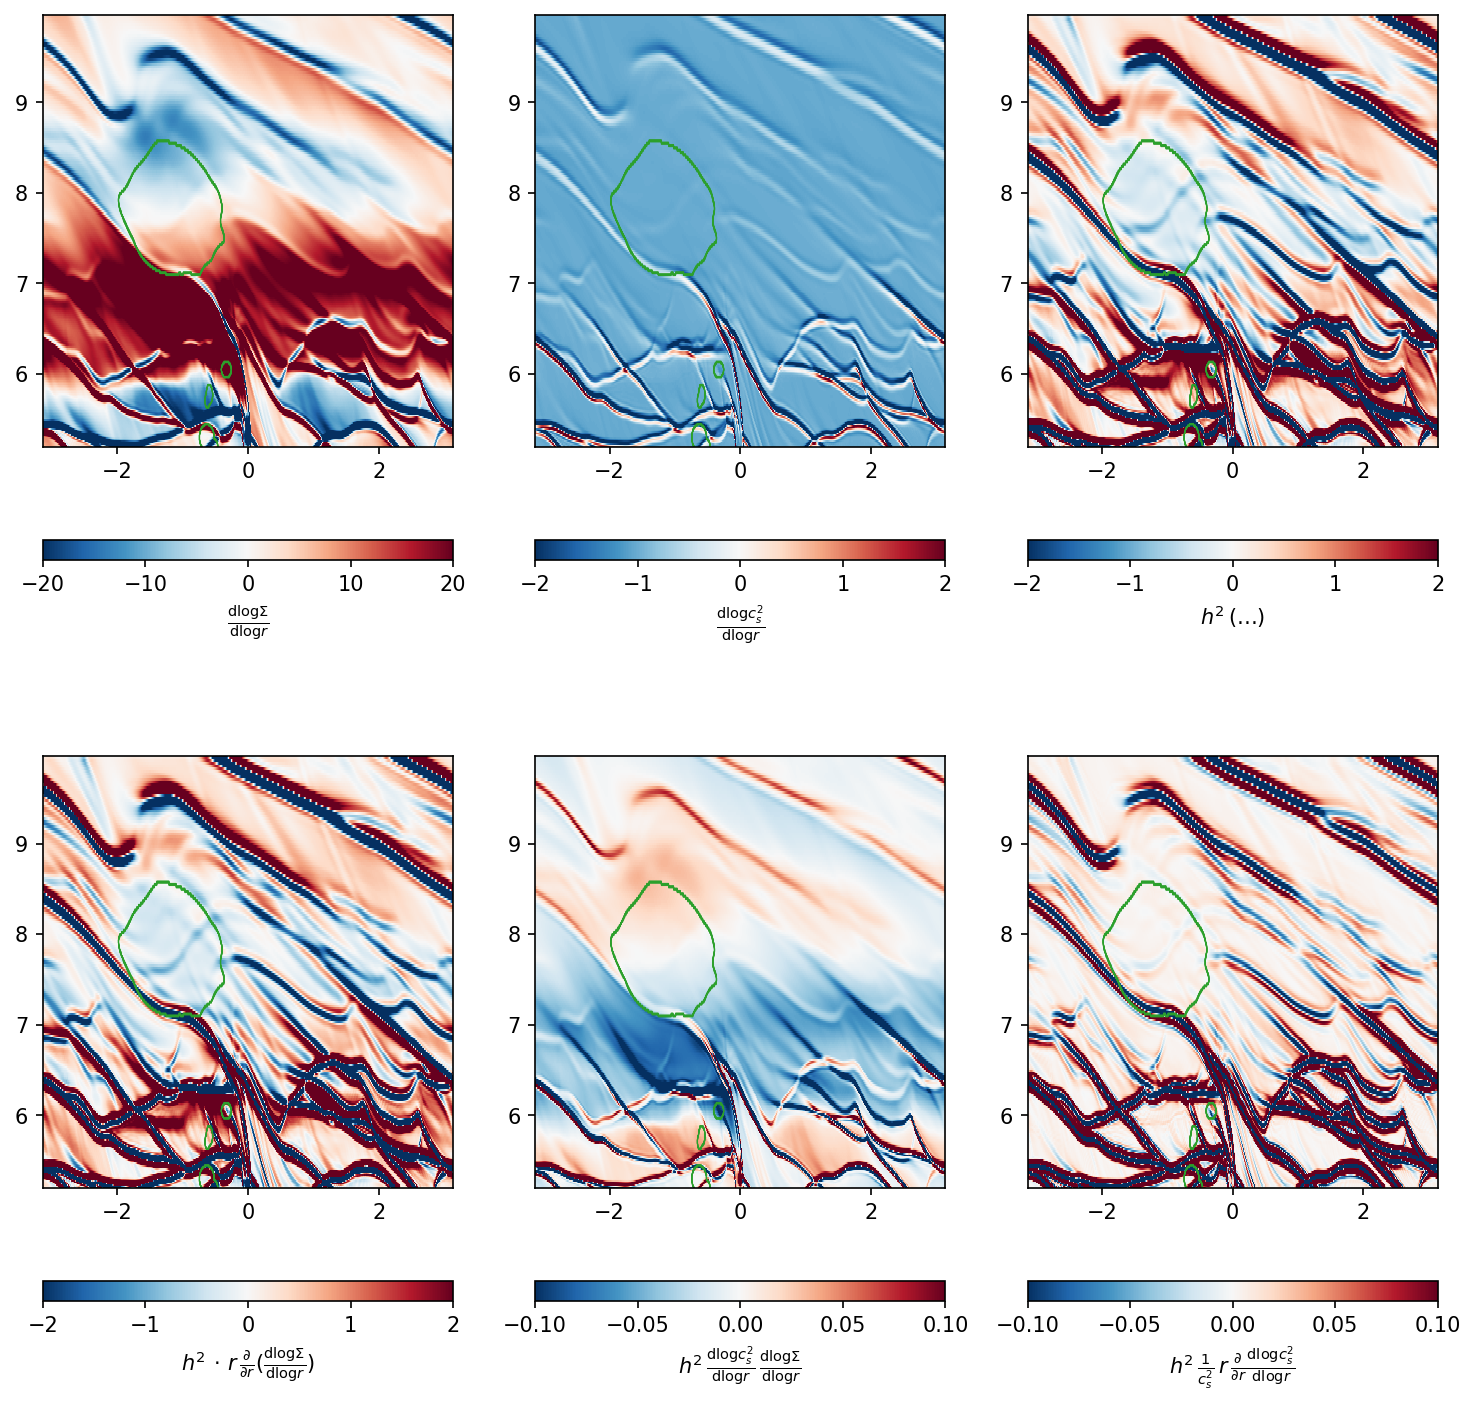

In [91]:
%matplotlib inline
fig, axes = plt.subplots(2,3,dpi=150, figsize=(12,12))
axes=axes.ravel()
s = np.gradient(np.log(Rho), R[:,0], axis=0)
ds_dr = np.gradient(R*s, R[:,0], axis=0)
dlogSigma_dlogr = np.gradient(np.log(Rho), np.log(R[:,0]), axis=0)

dlogcs2_dlogr = np.gradient(np.log(Cs2_adb), np.log(R[:,0]), axis=0)

term1 = R*ds_dr*h**2
term2 = h**2*dlogcs2_dlogr * dlogSigma_dlogr
term3 = h**2* np.gradient(Cs2_adb*dlogcs2_dlogr, np.log(R[:,0]), axis=0) / Cs2_adb

gamma = 1.4
h = 0.05

ax = axes[0]
vscale = 20
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dlogSigma_dlogr, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$")

ax = axes[1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dlogcs2_dlogr, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}$")

ax = axes[2]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term1+term2+term3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$h^2 \,(\dots)$")

ax = axes[3]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$h^2\,\cdot\, r\, \frac{\partial}{\partial r}  (\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r})$")

ax = axes[4]
vscale = 0.1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$h^2 \,\frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}\,\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$")

ax = axes[5]
vscale = 0.1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, term3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$h^2 \, \frac{1}{c_s^2} \,r\, \frac{\partial}{\partial r} \frac{\mathrm{d log} c_s^2}{\mathrm{d log}r}$")



# show vortex contour
for vort in vd.vortices:
    for ax in axes:
        ax.contour(Phi, R, vd.get_mask(vort, region="combined"), colors="C2", linewidths=0.5)

Text(0, 0.5, '$\\frac{\\mathrm{d log} \\Sigma}{\\mathrm{d log}r}$')

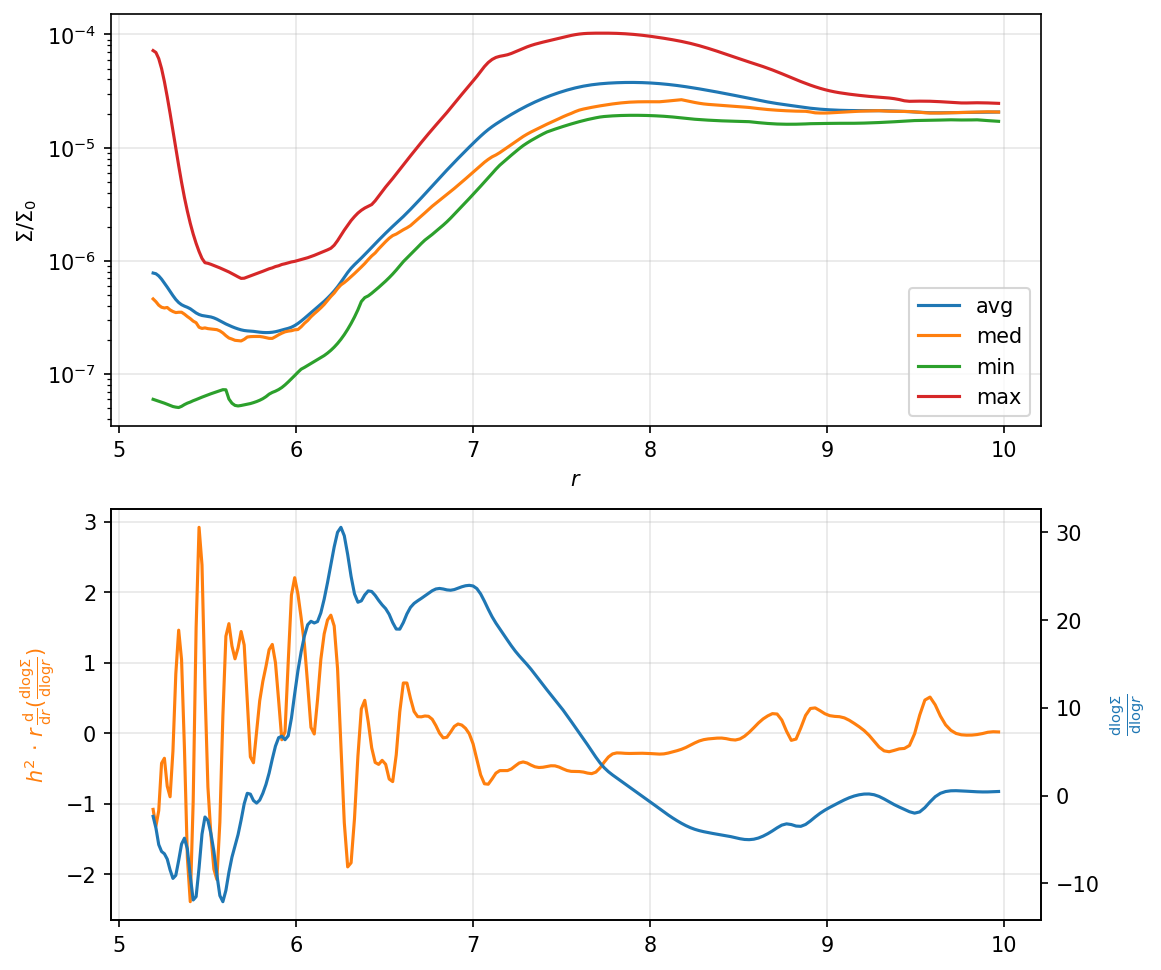

In [95]:
%matplotlib inline
fig, axes = plt.subplots(2,1,dpi=150, figsize=(8,8))

ax = axes[0]
Z = Rho
ax.plot(R[:,0], np.average(Z, axis=1), label="avg")
ax.plot(R[:,0], np.median(Z, axis=1), label="med")
ax.plot(R[:,0], np.min(Z, axis=1), label="min")
ax.plot(R[:,0], np.max(Z, axis=1), label="max")
ax.set_yscale("log")
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel("$r$")
ax.set_ylabel("$\Sigma/\Sigma_0$")

gamma = 1.4
h = 0.05

ax = axes[1]
ax.plot(R[:,0], np.average(h**2*R*ds_dr, axis=1), color="C1")
ax.set_ylabel(r"$h^2 \,\cdot\, r\, \frac{\mathrm{d}}{\mathrm{d}r}  (\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}) $", color="C1")
ax.grid(alpha=0.3)
ax2 = ax.twinx()
ax2.plot(R[:,0], np.average(R*s, axis=1), color="C0")
ax2.set_ylabel(r"$\frac{\mathrm{d log} \Sigma}{\mathrm{d log}r}$", color="C0")

## Temperature

Text(0, 0.5, '$T$ [K]')

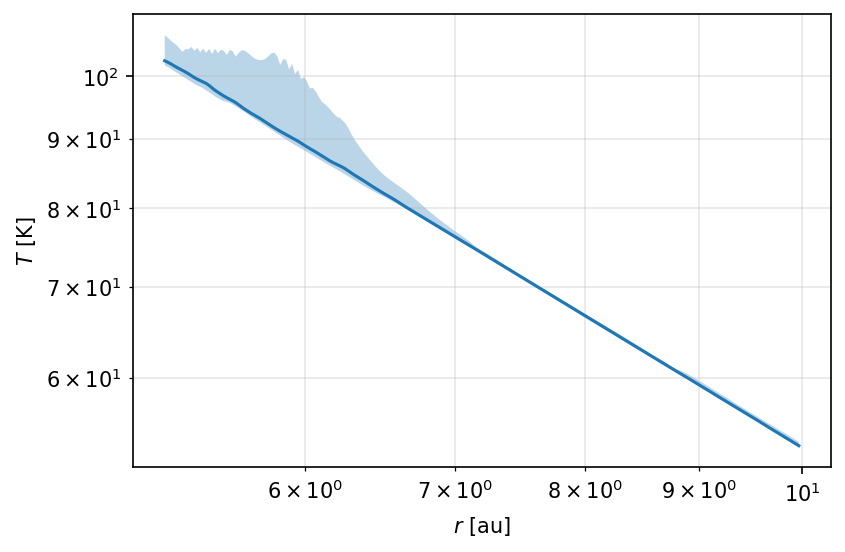

In [109]:
fig, ax = plt.subplots(dpi=150)
ax.plot(R[:,0], np.average(T, axis=1))
ax.fill_between(R[:,0], np.min(T, axis=1), np.max(T, axis=1), alpha=0.3)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=0.3, which="minor")
ax.grid(alpha=0.3, which="major")
ax.set_xlabel("$r$ [au]")
ax.set_ylabel("$T$ [K]")

## Lovelace Parameter

Defined in Lovelace et al. 1999, the Lovelace parameter give a measure of where the Rosby Wave instability can be triggered.

\begin{align}
\mathcal{L} = \frac{S^{2/\gamma}}{\bar{\omega}}
\end{align}

with the entropy, $S$, the adiabatic index ,$\gamma$, and the vortensity, $\bar{\omega} = \frac{\omega}{\Sigma}$.
$\omega = \hat{z}\cdot (\nabla \times \vec{v})$ is the vorticity.

Using $S = \frac{P}{\Sigma^\gamma}$

\begin{align}
\mathcal{L} = \frac{P^{2/\gamma}}{\Sigma \omega}
\end{align}

In [112]:
Lovelace = P**(2/gamma)/Rho/vorticity

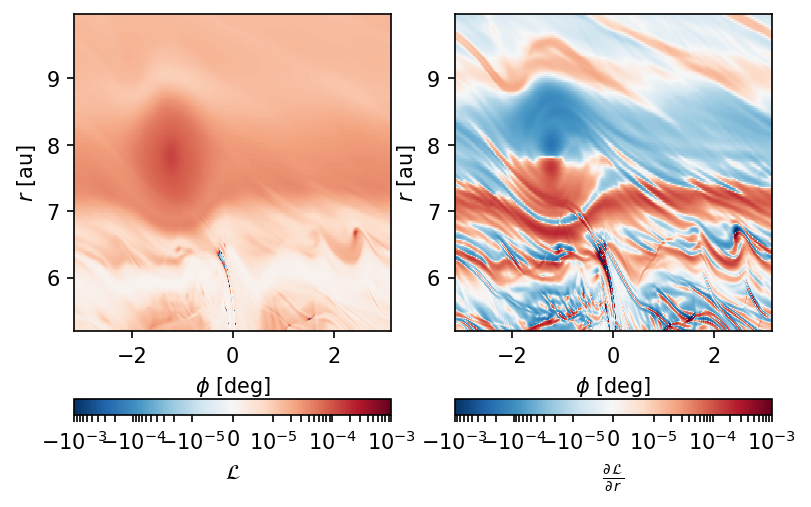

In [133]:
fig, axes = plt.subplots(1,2,dpi=150)

ax = axes[0]
vscale = 1e-3
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, Lovelace,
                   cmap="RdBu_r", 
                   norm=colors.SymLogNorm(
                       linthresh = 1e-5, vmin=vmin, vmax=vmax)
                  )
ax.set_xlabel("$\phi$ [deg]")
ax.set_ylabel("$r$ [au]")
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\mathcal{L}$")

ax = axes[1]
vscale = 1e-3
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, np.gradient(Lovelace, R[:,0], axis=0),
                   cmap="RdBu_r", 
                   norm=colors.SymLogNorm(
                       linthresh = 1e-5, vmin=vmin, vmax=vmax)
                  )
ax.set_xlabel("$\phi$ [deg]")
ax.set_ylabel("$r$ [au]")
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$\frac{\partial\,\mathcal{L}}{\partial\,r}$")

Text(0, 0.5, '$\\frac{\\partial\\,\\mathcal{L}}{\\partial\\,r}$')

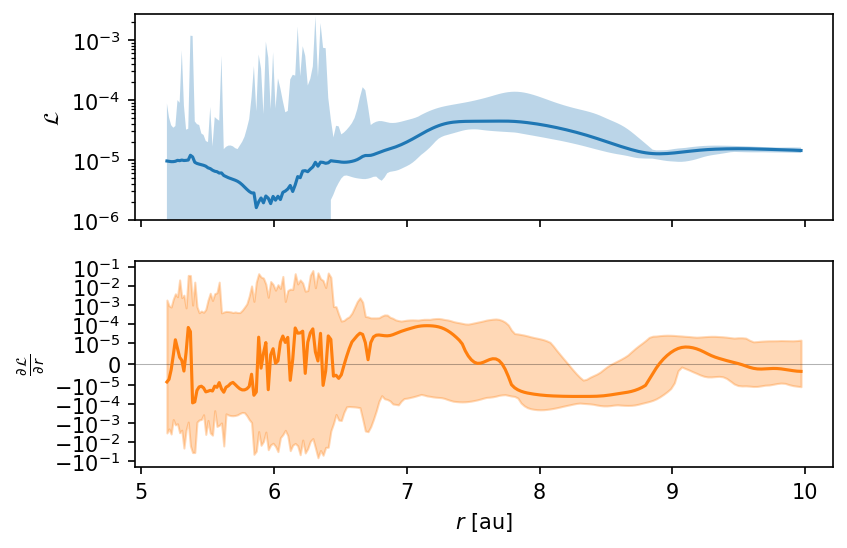

In [158]:
fig, axes = plt.subplots(2,1,dpi=150, sharex="all")

Q = Lovelace
ax = axes[0]
ax.plot(R[:,0], np.average(Q, axis=1))
ax.fill_between(R[:,0], np.min(Q, axis=1), np.max(Q, axis=1), alpha=0.3)

vmin = 1e-6
ax.set_ylim(bottom=vmin)
ax.set_yscale("log")
# ax.set_xlabel("$r$ [au]")
ax.set_ylabel("$\mathcal{L}$")

ax = axes[1]
Q = np.gradient(Lovelace, R[:,0], axis=0)
ax.axhline(0, alpha=0.3, color="k", lw=0.5)
ax.plot(R[:,0], np.average(Q, axis=1), color="C1")
ax.fill_between(R[:,0], np.min(Q, axis=1), np.max(Q, axis=1), alpha=0.3, color="C1")
ax.set_yscale("symlog", linthresh=1e-5)
ax.set_xlabel("$r$ [au]")
ax.set_ylabel(r"$\frac{\partial\,\mathcal{L}}{\partial\,r}$")